We are using **ResNet18** CNN in the notebook. Classify onjects in 1000 categories

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"{device} is being used")

cuda is being used


In [3]:
# # different values are used for 3 diffn channels

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

### Deleting data folder if exists

In [4]:
import shutil
import os

# Define the directory path
dir_path = 'data'

# Remove the directory and all its contents
if os.path.exists(dir_path) and os.path.isdir(dir_path):
    shutil.rmtree(dir_path)
    print(f"{dir_path} folder and all its contents have been deleted.")
else:
    print(f"{dir_path} folder does not exist.")

data folder does not exist.


### Downloading the data

In [5]:
from urllib.request import urlretrieve
import zipfile

data_dir = "data"

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

if not os.path.exists(data_dir):
    filename = "hymenoptera_data.zip"
    urlretrieve(url, filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(filename)  # Clean up by removing the zip file

Purpose is to perform **Training and Validation Augmentation**

**transforms.Compose()** -> Combines multiple transformation functions into one. These transformations will be applied in sequence to the input images.

**transforms.ToTensor()**->Converts the image from a PIL image or NumPy array to a PyTorch tensor. This transformation also scales the pixel values to a range between 0 and 1

In [6]:
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

**ImageFolder** automatically assigns labels to the images based on the subfolder names. Creates an in-memory dataset object. The labels are stored as part of this dataset object but are not saved separately as files. Instead, they are part of the dataset that is accessible through PyTorch utilities like **DataLoader**

In [7]:
data_dir = "data/hymenoptera_data"
sets = ['train', 'val']

image_datasets = {
    x:datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in sets
}

In [8]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
dataloaders = {
    x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
    for x in sets
}

In [10]:
dataloaders['train']

### Viewing data
Shows Normalized Images

torch.Size([4, 3, 224, 224]) torch.Size([4])


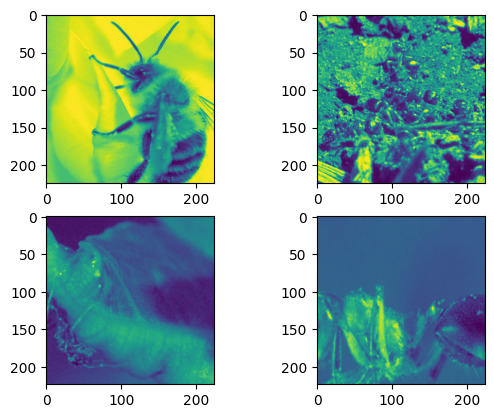

In [11]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)
print(images.shape, labels.shape)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0])
plt.show()

**transpose((1, 2, 0))**: Rearranges the dimensions of the NumPy array from [C, H, W] to [H, W, C]. This is necessary because matplotlib expects the image array to have the height and width dimensions first, followed by the channels

**std * inp + mean**: This line undoes the normalization applied to the image during preprocessing. Typically, images are normalized with a mean and standard deviation (e.g., mean and std), and this line reverses that normalization to get the image back to its original scale.

**np.clip(inp, 0, 1)**: Ensures that all pixel values in the image are within the range [0, 1]. This is useful because pixel values should be between 0 and 1 after denormalization. Clipping ensures that any values outside this range are fixed to the nearest boundary (0 or 1).


In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


In [13]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


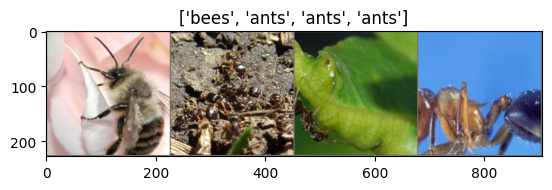

In [14]:
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
print(dataset_sizes)

{'train': 244, 'val': 153}


### Define the model

**model.state_dict()**: This is a method in PyTorch that returns a dictionary containing all the model parameters (weights and biases), running mean, variance . This dictionary maps each layer to its corresponding parameter tensor.

**Deep copy**: A deep copy duplicates everything, including all nested elements, effectively creating a completely separate copy of the original data

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-"*10)

        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # inputs shape = (4, 3, 224, 224])
            # labels shape = (4)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(input=outputs, dim=1)
                    # Here loss is a scalar quantity, represents the average loss per sample
                    loss = criterion(outputs, labels)

                    if phase=='train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # To get the loss for the whole batch, we multiply it by batch_size
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Using transfer learning

#### **A. Full Fine Tuning** : In this case, last layer is changed and the whole layers will be trained again

**fc** is the last layer of the model.

**(fc): Linear(in_features=512, out_features=1000, bias=True)**

****************************
Using learning rate scheduler, : At the beginning of training, we might want a higher learning rate to make rapid progress in optimizing the loss function. Towards the end, we might lower the learning rate to fine-tune the model and avoid overshooting the minima of the loss function.

In [17]:
model = models.resnet18(pretrained=True)
print(model)
# Number of input features for fully connected layers
num_ftrs = model.fc.in_features
# Defining own FC layer where input_dim will the same and output dim will be 2 instead of 1000.
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Scheduler for updating the learning rate
# At every 7th epoch, lr will be multiplied by gamma
step_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### **B. Only the newly added layers will be trained, rest all the layers will ramin frozen and will retain their existing weights**

In [18]:
model = models.resnet18(pretrained=True)
# Freeze all the layers
for param in model.parameters():
    param.requires_grad=False

# Number of input features for fully connected layers
num_ftrs = model.fc.in_features

# Defining own FC layer where input_dim will the same and output dim will be 2 instead of 1000.
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Scheduler for updating the learning rate
# At every 7th epoch, lr will be multiplied by gamma
step_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.7683 Acc: 0.6516
val Loss: 0.3905 Acc: 0.8170

Epoch 2/20
----------
train Loss: 0.4937 Acc: 0.7500
val Loss: 0.2094 Acc: 0.9346

Epoch 3/20
----------
train Loss: 0.5086 Acc: 0.8238
val Loss: 0.2258 Acc: 0.9412

Epoch 4/20
----------
train Loss: 0.6658 Acc: 0.7049
val Loss: 0.1871 Acc: 0.9346

Epoch 5/20
----------
train Loss: 0.5371 Acc: 0.7869
val Loss: 0.3357 Acc: 0.8824

Epoch 6/20
----------
train Loss: 0.6932 Acc: 0.7541
val Loss: 0.4426 Acc: 0.8301

Epoch 7/20
----------
train Loss: 0.6669 Acc: 0.7541
val Loss: 0.1926 Acc: 0.9477

Epoch 8/20
----------
train Loss: 0.3576 Acc: 0.8689
val Loss: 0.1957 Acc: 0.9542

Epoch 9/20
----------
train Loss: 0.3162 Acc: 0.8770
val Loss: 0.2169 Acc: 0.9477

Epoch 10/20
----------
train Loss: 0.4366 Acc: 0.8074
val Loss: 0.1935 Acc: 0.9542

Epoch 11/20
----------
train Loss: 0.3122 Acc: 0.8607
val Loss: 0.1894 Acc: 0.9542

Epoch 12/20
----------
train Loss: 0.4213 Acc: 0.8361
val Loss: 0.2252 Acc: 0.9477

E